# Cognitive Data  Linear Regression Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pds
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from utils import make_machine_learning_df, plot_countplot_row, plot_patient_age_gender, make_lmplot_df
%matplotlib inline 

## load data
* `adj_df` holds data adjusted with the survey weights
* `base_df` holds non-adjusted survey weight data

In [3]:
adj_df = make_machine_learning_df(weight_divisor=1000)
base_df = make_machine_learning_df(use_survey_weight=False)

print(f'adjusted len:{len(adj_df)} \nbase/raw len: {len(base_df)}')

adjusted len:8554 
base/raw len: 313


### compare adjusted and base counts
Inerestingly, both the base and adjusted dataframes have a high number of patients >= 80.  
The adjusted dataframe also has less patients in the 60-63 age range.

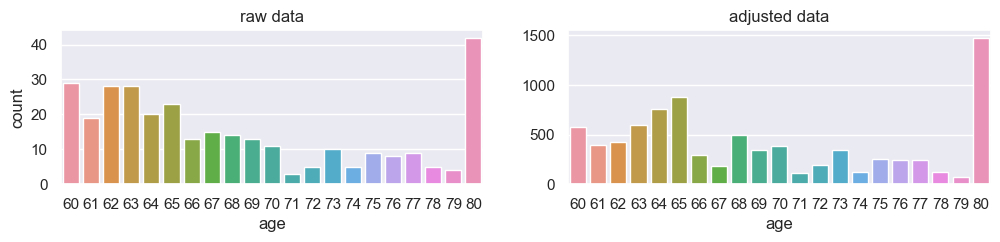

In [4]:
%matplotlib inline
sns.set_theme()
dfs = [base_df, adj_df]
titles = ["raw data", "adjusted data"]
plot = plot_countplot_row(dfs, 'age', titles=titles, hues=[None, None], figsize=(12, 2)).show()

compare age by gender

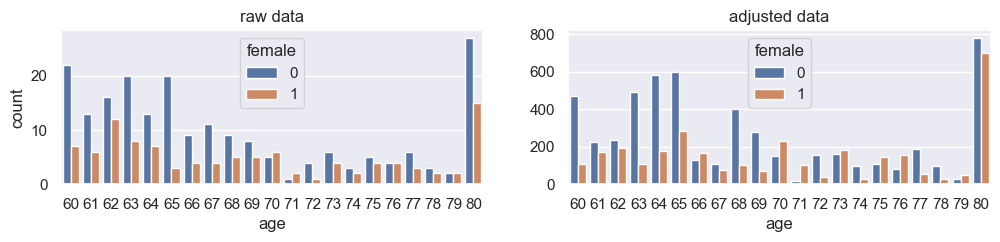

In [5]:
dfs = [base_df, adj_df]
titles = ["raw data", "adjusted data"]
plot = plot_countplot_row(dfs, 'age', titles=titles, hues=['female', 'female'], figsize=(12, 2)).show()

## linear regression analysis

### augment data with cognitive scores
In order to linear regresssion, you will need the actual scores of the patients. Not just the low cognitive score indicator.  
variables:
* `cerad_sum`: sum of all cerad tests
* `cfdds`: digit symbol score
* `cfdast`: total animal fluency score

In [6]:
scores = ['cerad_sum', 'cfdds', 'cfdast']

In [7]:
cog_score_df = (
    pds.read_csv('../data/nhanescog_2011_12_CSV.csv', usecols=scores + ['seqn', 'age_cat'])
    .rename(columns={'seqn': 'SEQN', 'cfdds': 'digit_symbol', 'cfdast': 'animal_fluency'})
    .set_index('SEQN')
    .dropna()
)
len(cog_score_df)

1361

In [8]:
cog_adj_df = adj_df.merge(cog_score_df, how='inner', on='SEQN')
assert len(adj_df) == len(cog_adj_df) # adding scores should change the number rows

In [9]:
cog_adj_df.head()

,female,age,low_global_re,pct_teeth_gt_3,pct_teeth_gt_4,pct_teeth_gt_5,pct_teeth_gt_6,age_cat,animal_fluency,digit_symbol,cerad_sum
SEQN,,,,,,,,,,,
62174,0,80,0.0,0.44,0.11,0.0,0.0,3.0,18.0,33.0,21.0
62174,0,80,0.0,0.44,0.11,0.0,0.0,3.0,18.0,33.0,21.0
62174,0,80,0.0,0.44,0.11,0.0,0.0,3.0,18.0,33.0,21.0
62174,0,80,0.0,0.44,0.11,0.0,0.0,3.0,18.0,33.0,21.0
62174,0,80,0.0,0.44,0.11,0.0,0.0,3.0,18.0,33.0,21.0


---

### sanity check
As a sanity check, compare age and cognitive score. The cognitive score should go *down* as age increases. 
`x_estimator=np.mean` is used to calculate mean of each bin. It makes the trend easier to see.  

Note: I've renamed colums to be `digit_symbol` and `animal_fluency` for readability.

In [14]:
plot_df = make_lmplot_df(cog_adj_df) # create dataframe needed for plots
# plot_df.head()

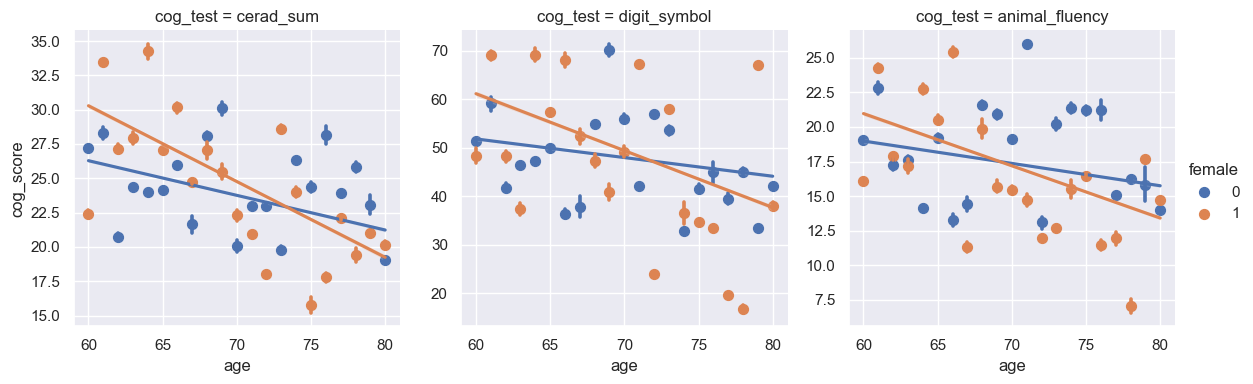

In [18]:
sns.lmplot(data=plot_df, x='age', y='cog_score', hue='female', height=4, col='cog_test', facet_kws={'sharey':False}, x_estimator=np.mean)
plt.show()

---

## analyze CAL by cog_test
The **columns** in the grid are determined by the cognitive test performed:
* cerad_sum
* digit_symbol
* animal_fluency

The **rows** in the grid are determined by the percentage of teeth with that amount of CAL:
* cal>3 (i.e., pct_teeth_gt_3)
* cal>4 (i.e., pct_teeth_gt_4)
* cal>5 (i.e., pct_teeth_gt_5)
* cal>6 (i.e., pct_teeth_gt_6)

**Female** information is in orange. **Male** information is in blue.


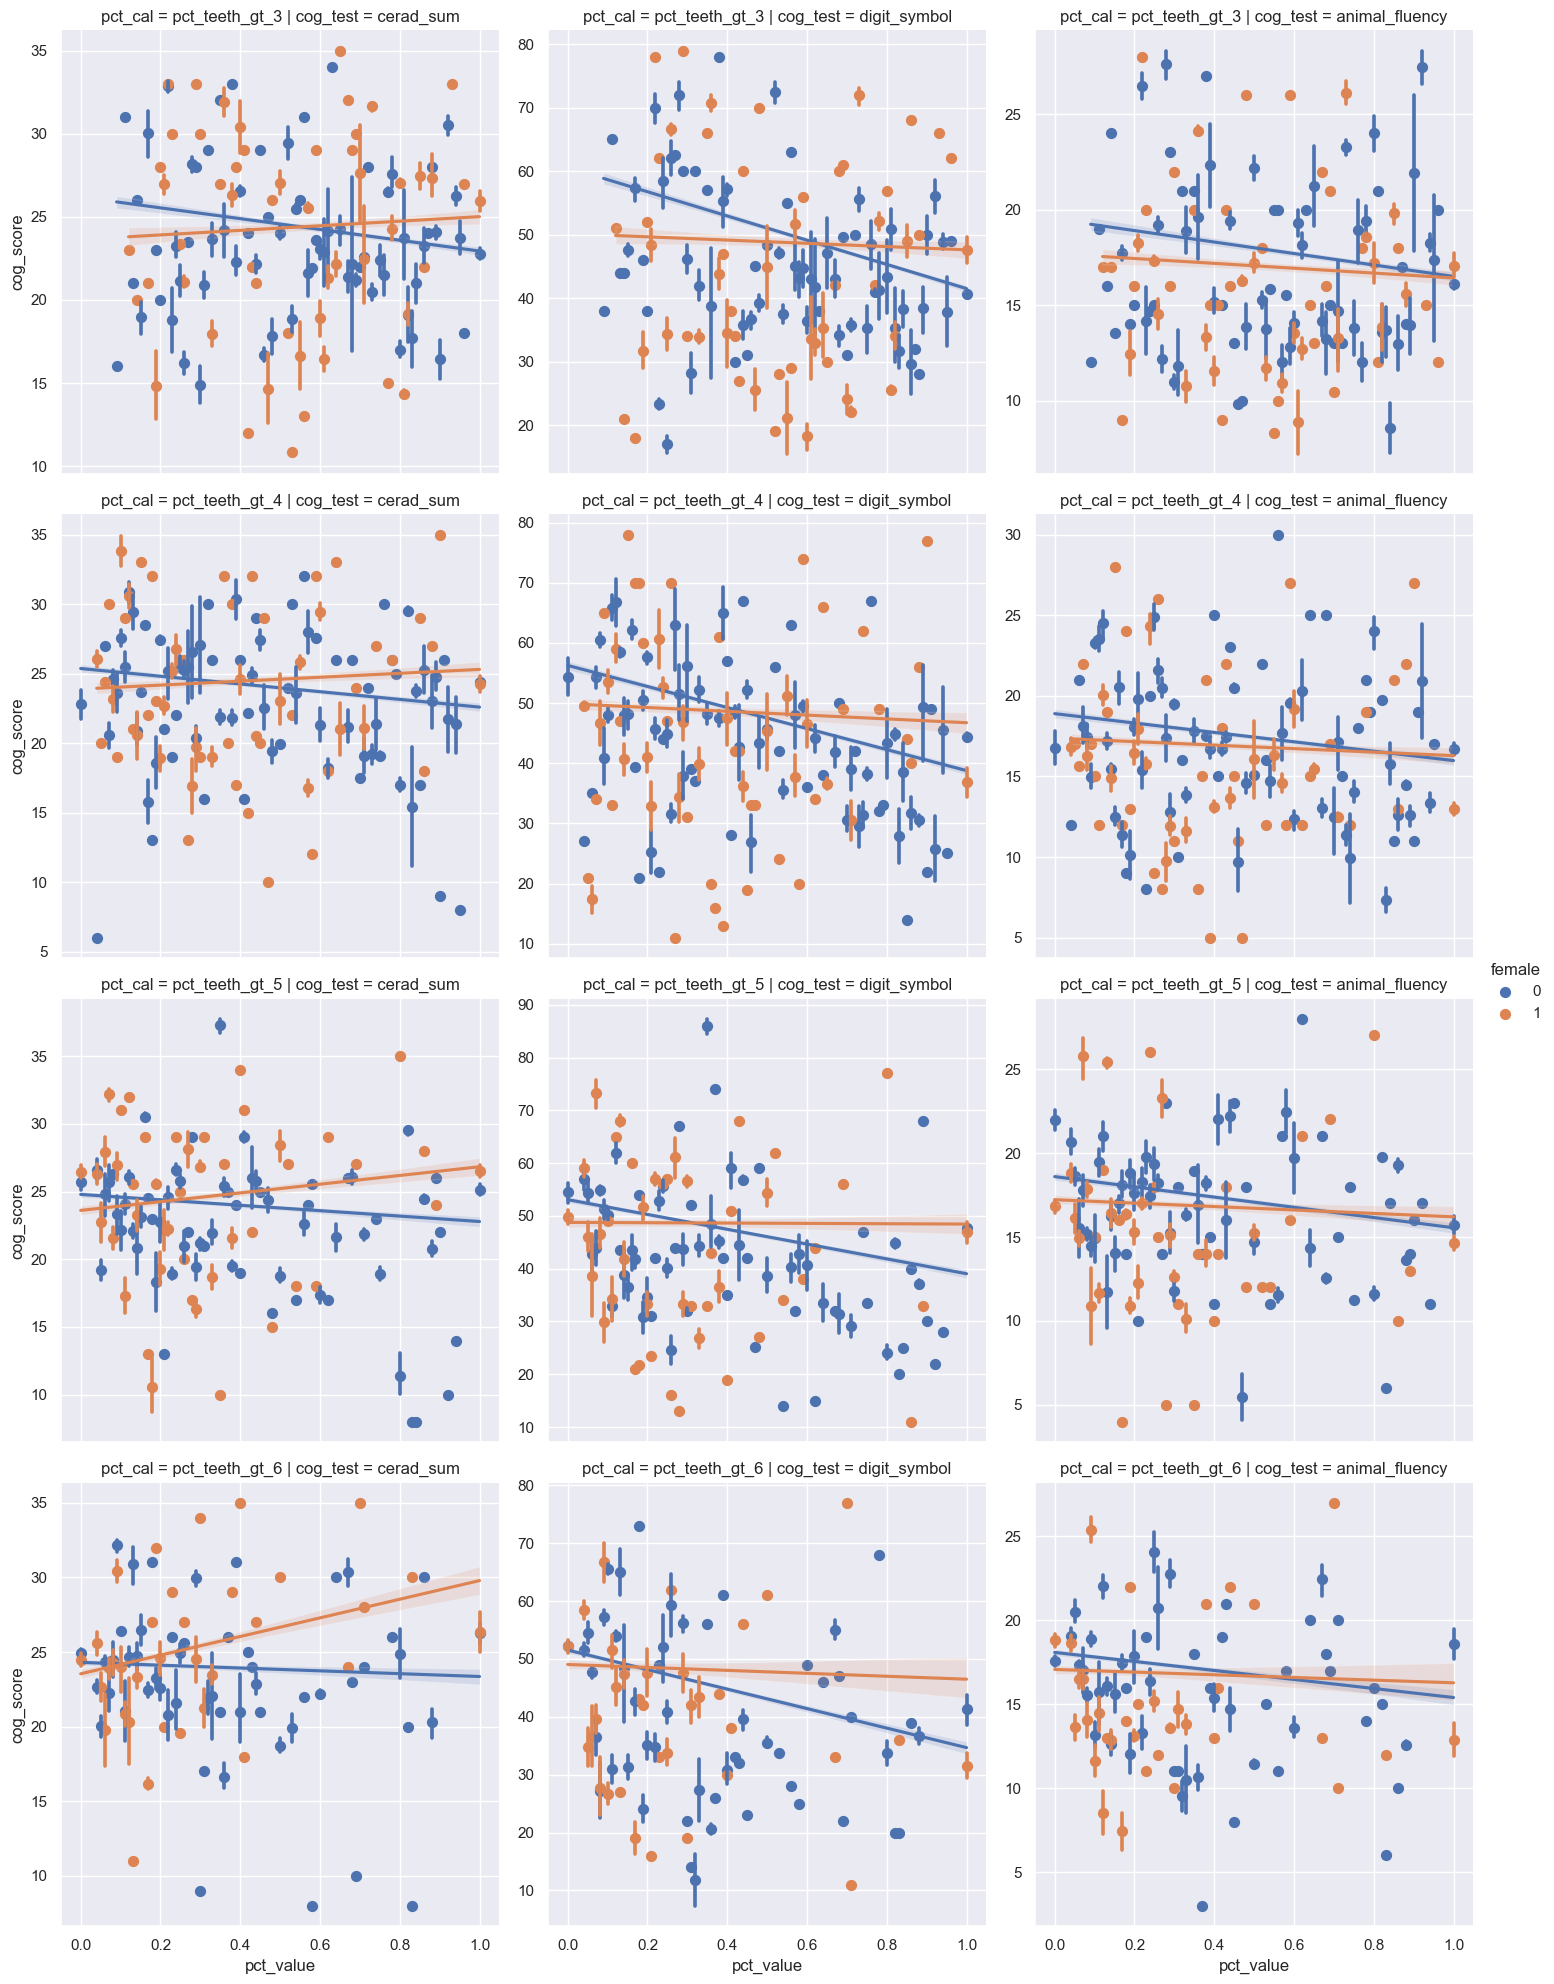

In [16]:
sns.lmplot(data=plot_df, x='pct_value', y='cog_score', hue='female', height=5, col='cog_test', row='pct_cal', facet_kws={'sharey':False}, x_estimator=np.mean)
plt.show()

---

## analysis by age
Similar to above, but data is divided into age categories:
* 1: 60-69
* 2: 70-79
* 3: 80+

## age 60-69

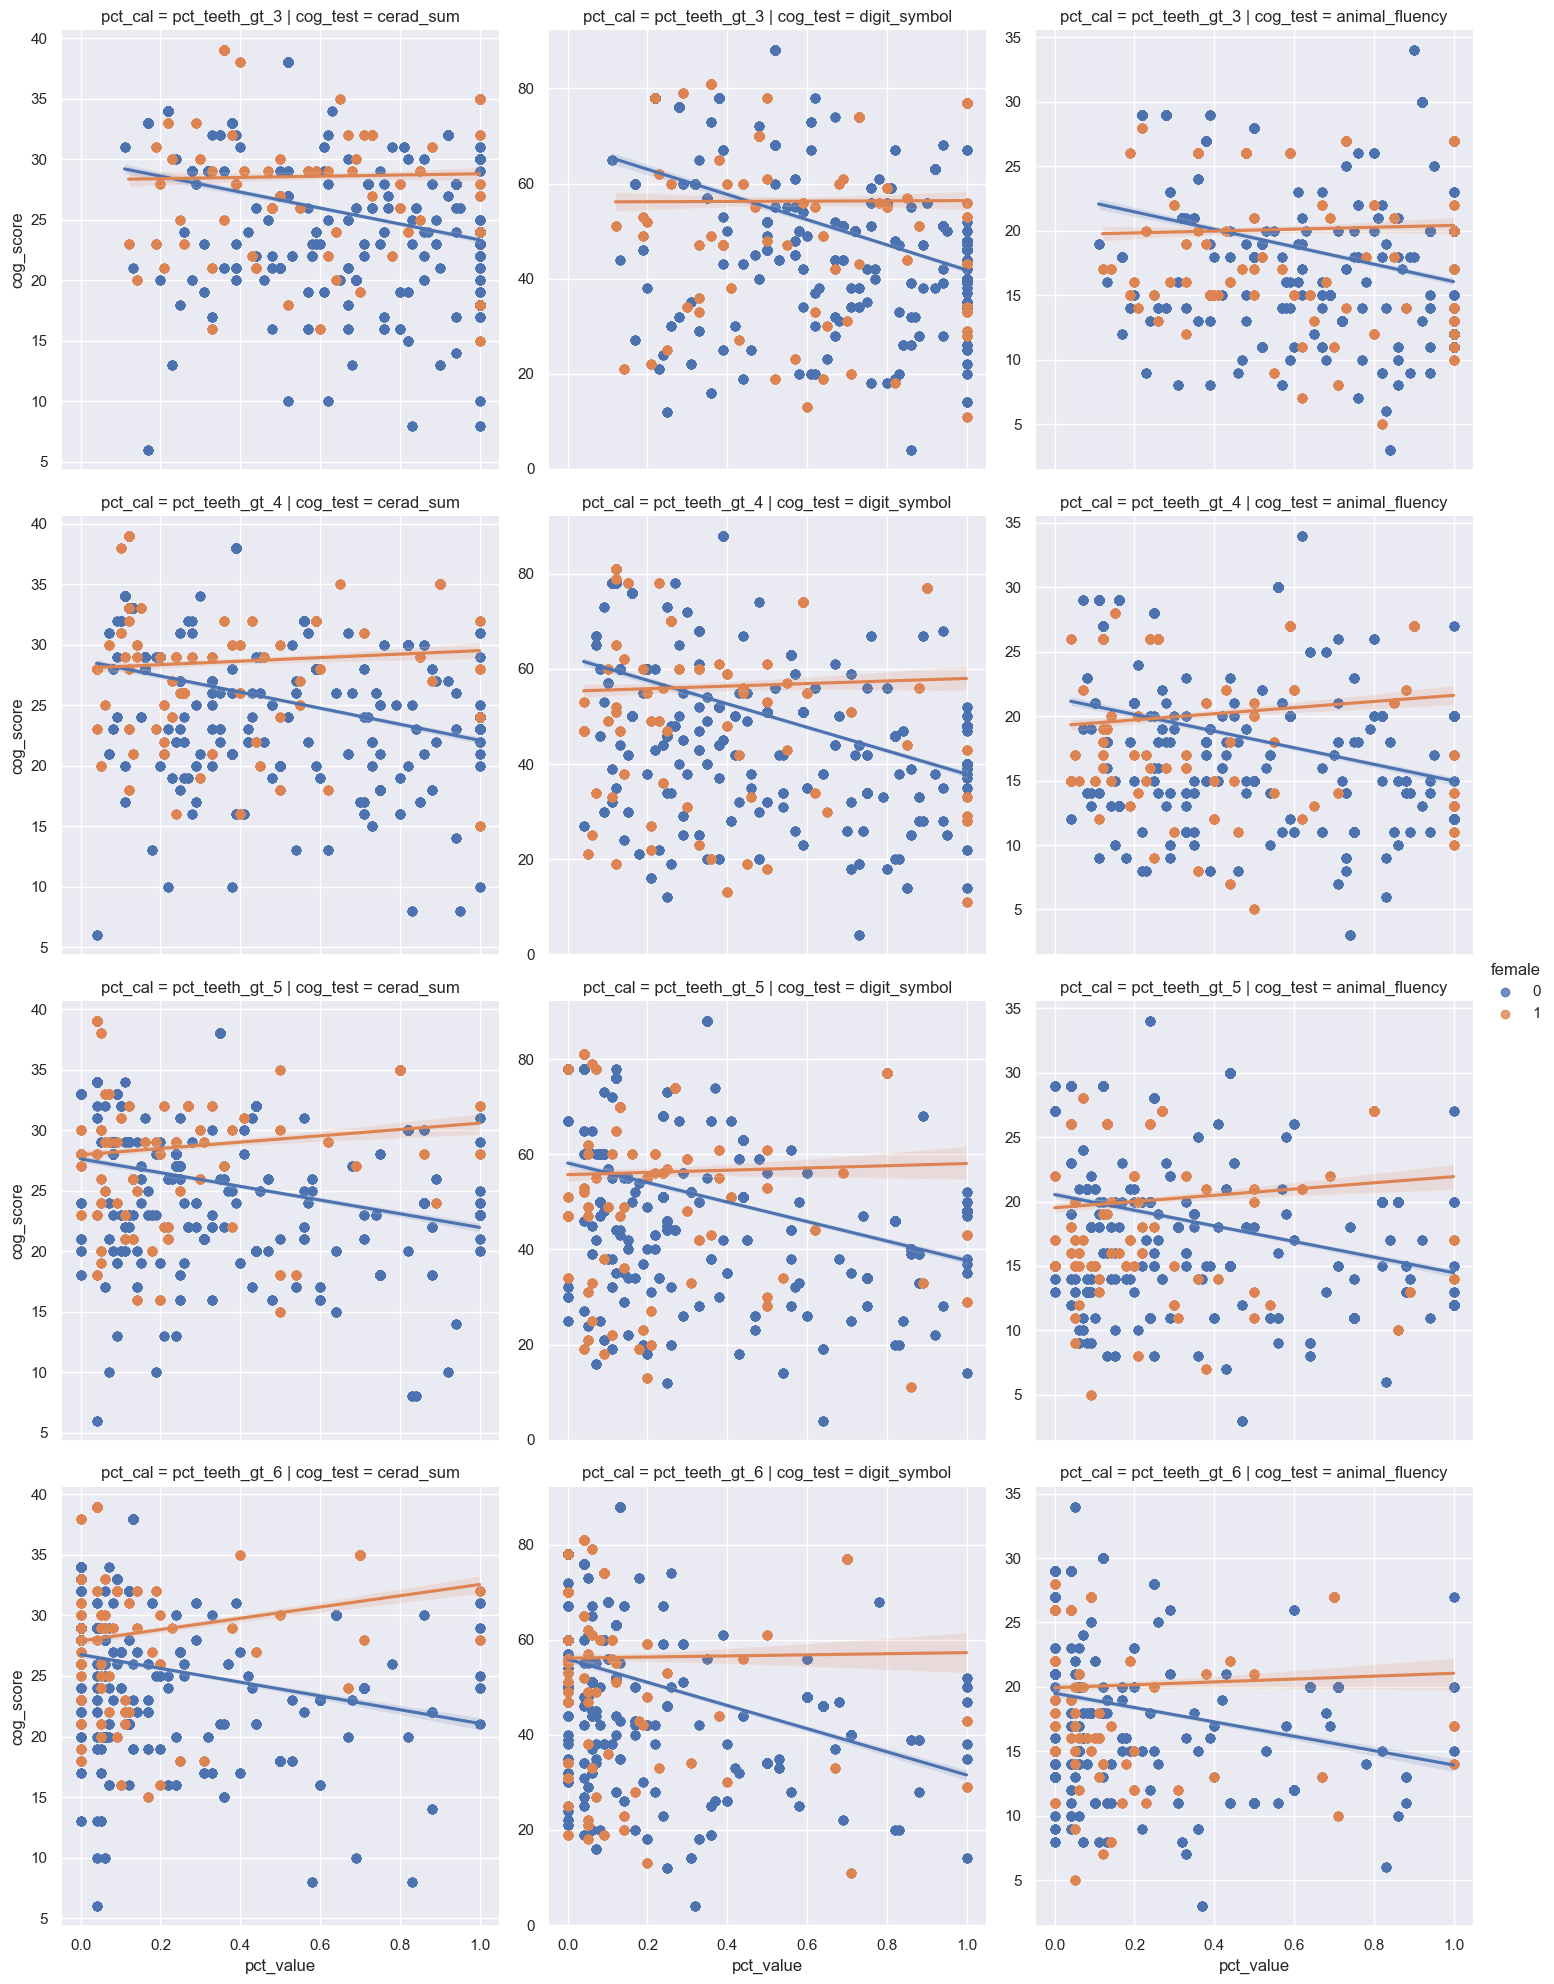

In [90]:
sns.lmplot(
    data=plot_df.query("age_cat == 1"), 
    x='pct_value', y='cog_score', hue='female', height=5, col='cog_test', row='pct_cal', facet_kws={'sharey':False})
plt.show()

---

## age 70-79

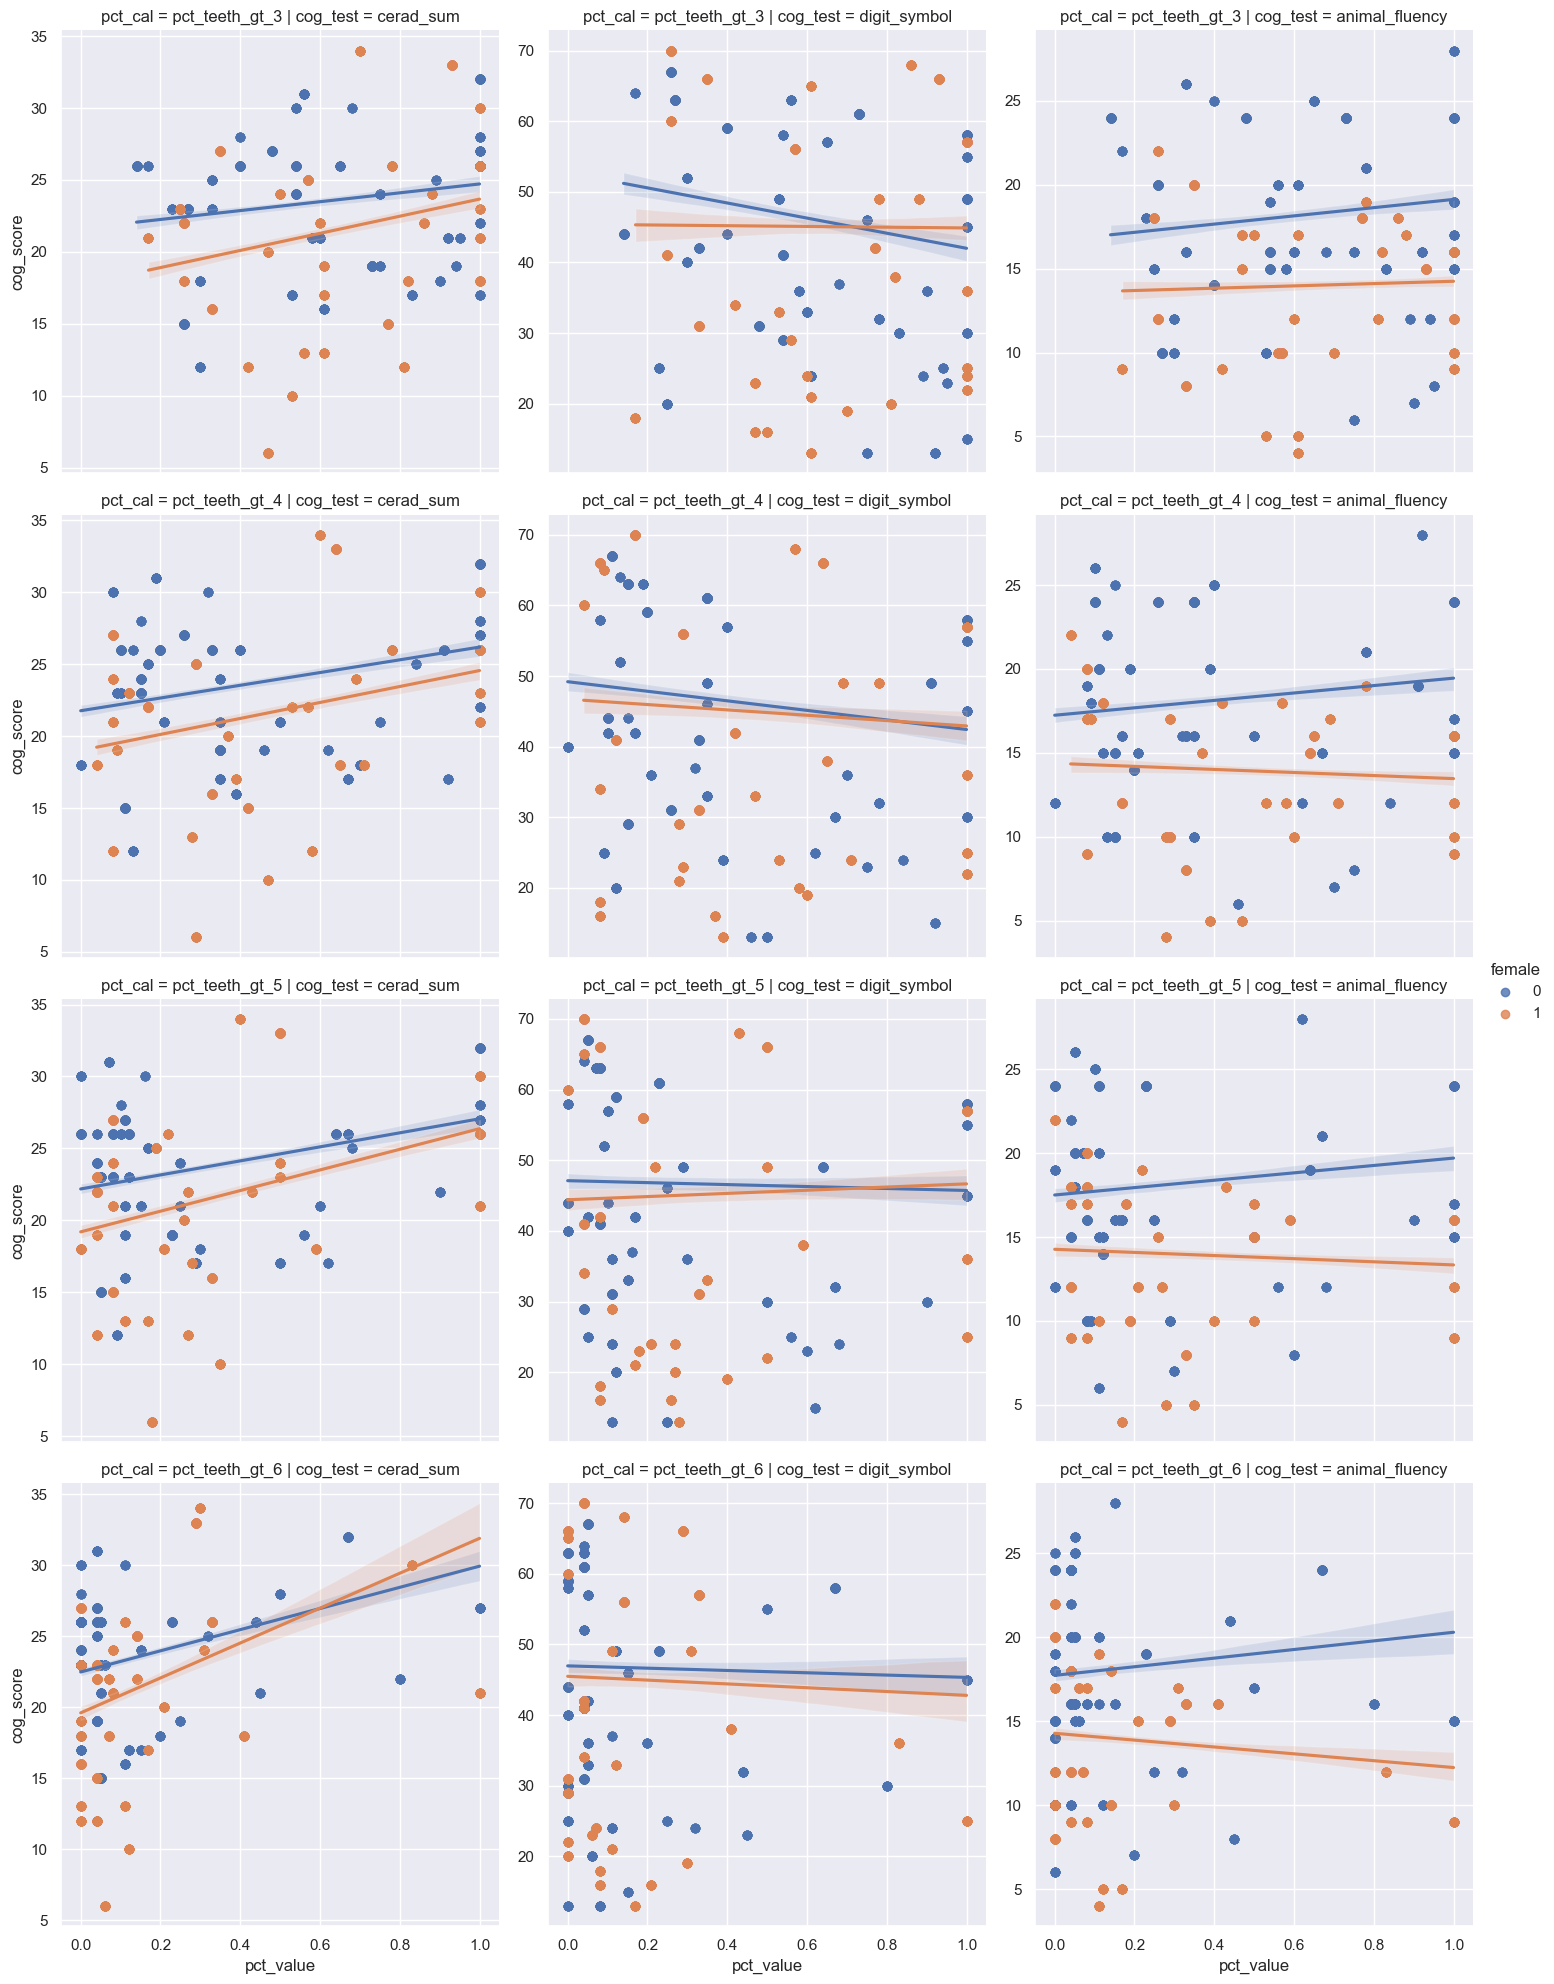

In [88]:
sns.lmplot(
    data=plot_df.query("age_cat == 2"), 
    x='pct_value', y='cog_score', hue='female', height=5, col='cog_test', row='pct_cal', facet_kws={'sharey':False})
plt.show()

---

## age 80+

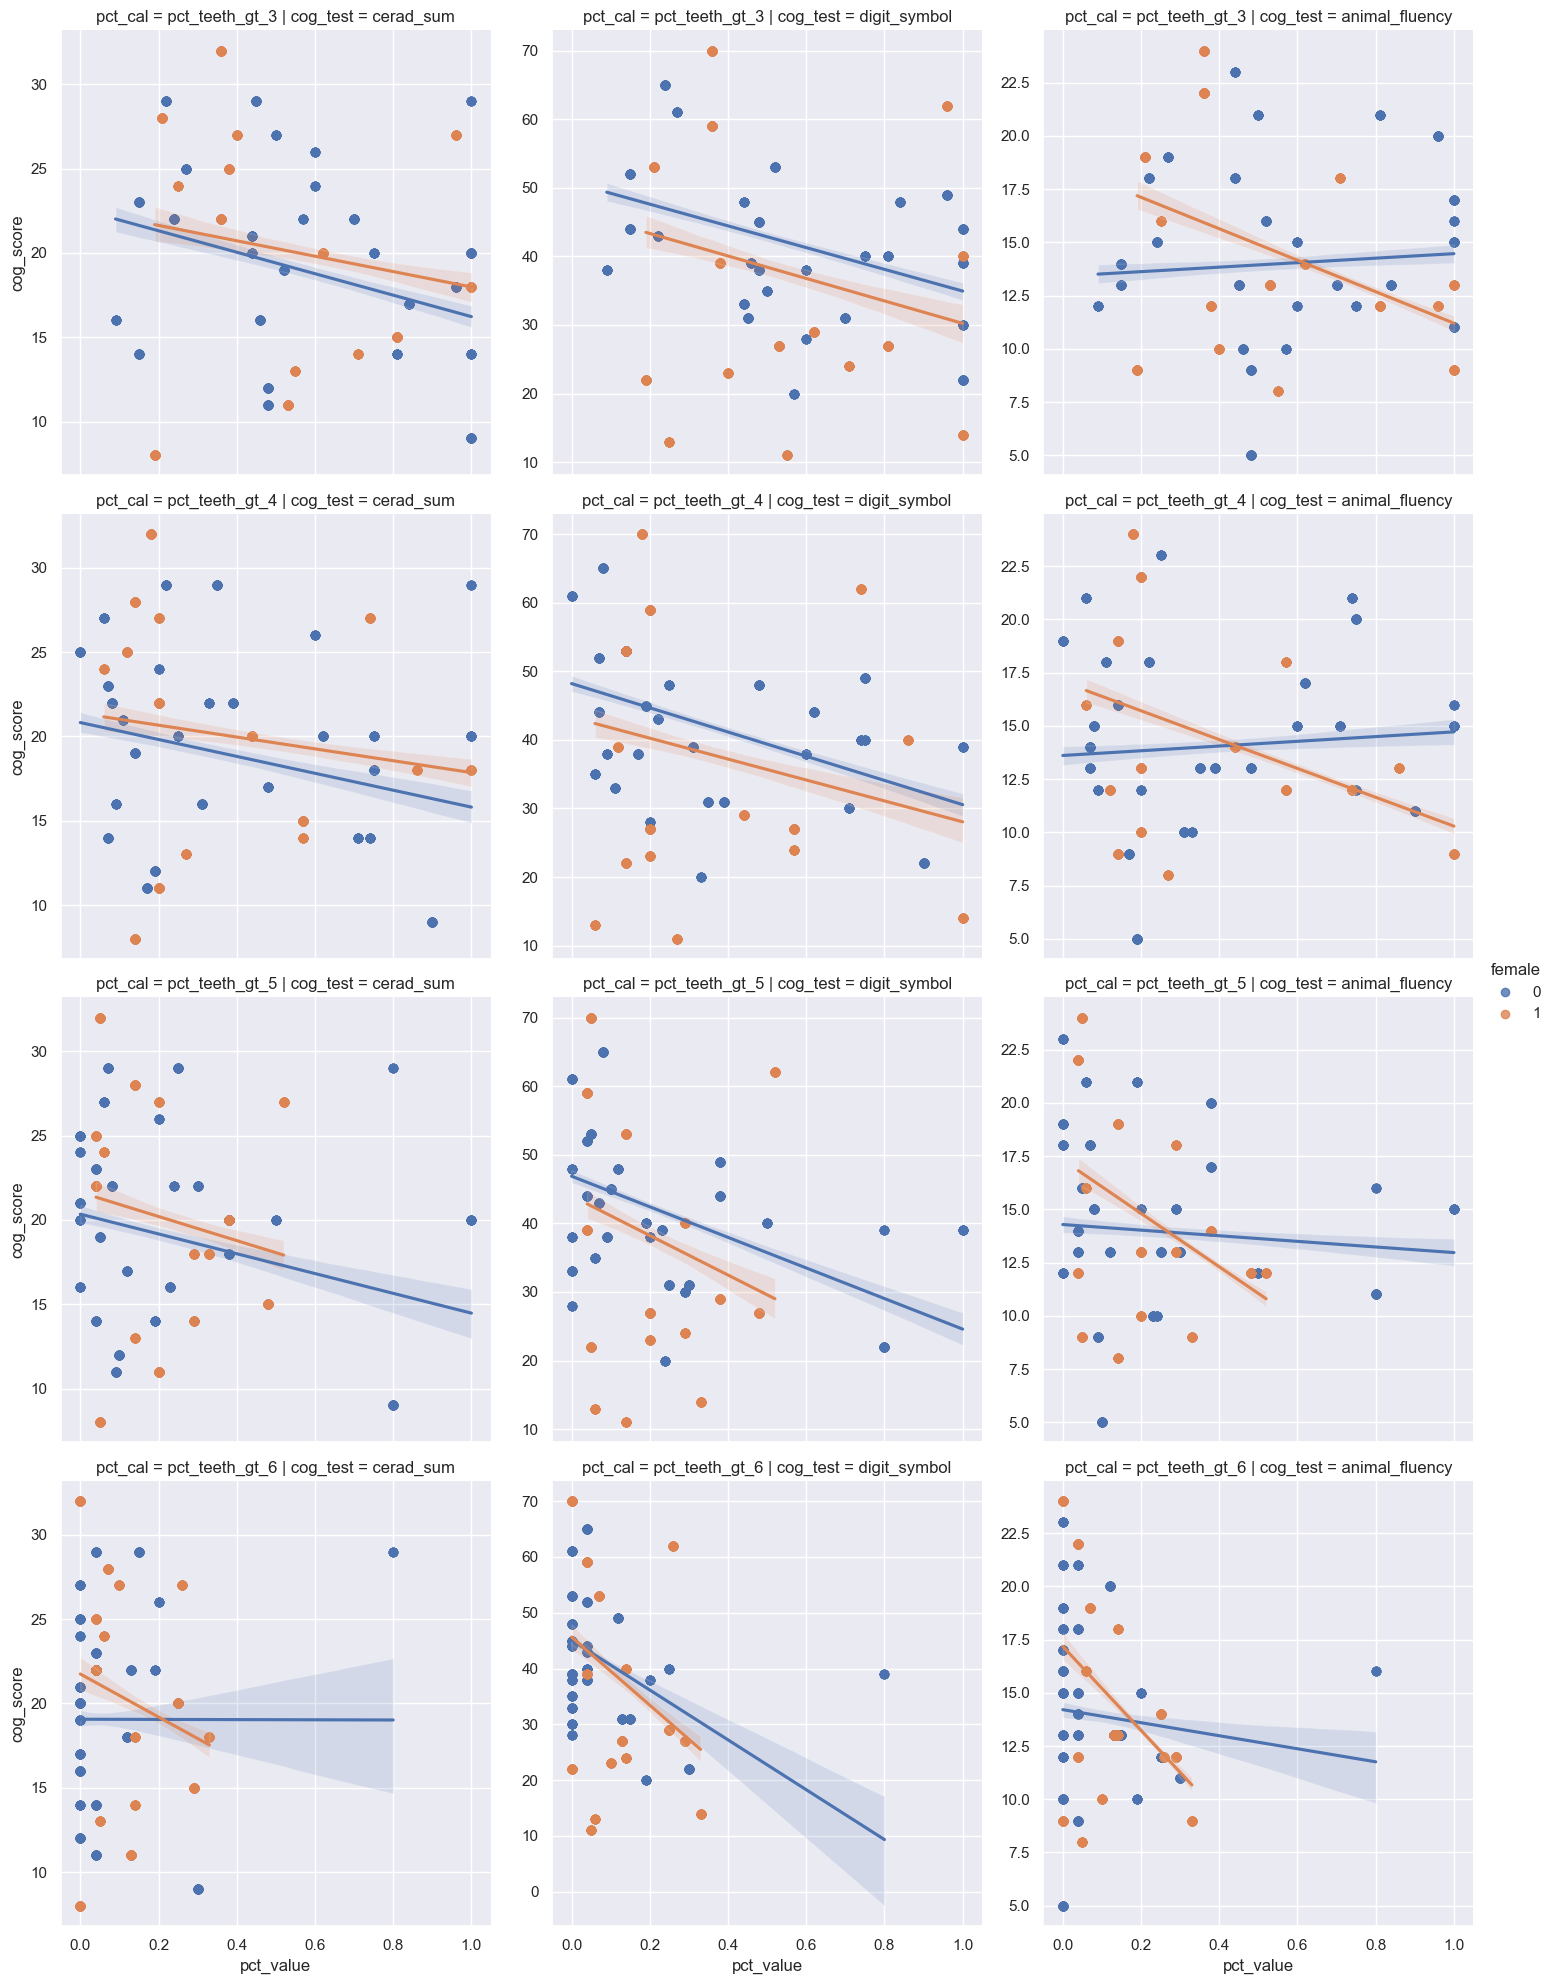

In [89]:
sns.lmplot(
    data=plot_df.query("age_cat == 3"), 
    x='pct_value', y='cog_score', hue='female', height=5, col='cog_test', row='pct_cal', facet_kws={'sharey':False})
plt.show()